In [4]:
import importlib
import sys,os,math,time

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import pylab as plt
import json
import pycrs
import seaborn as sns

from shapely.geometry import Point
from rasterio.plot import show, show_hist
from rasterio.mask import mask

import GOSTnet as gn
from pandana.loaders import osm;

from osgeo import gdal, gdalconst, gdal_array
from rasterstats import point_query, zonal_stats
from make_fishnet import make_fishnet

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 


In [6]:
boundary_GDF = ox.gdf_from_place('Kampala',which_result=2)
boundary_GDF
boundary_poly = boundary_GDF.loc[0,'geometry']    # boundary as shapely polygon

In [7]:
pop_raster = rasterio.open('data/kampala_pop_2.tiff')
coords = (pop_raster.bounds[1], pop_raster.bounds[0], pop_raster.bounds[3], pop_raster.bounds[2])

In [8]:
path = 'data'
tif_10_proj_path = os.path.join(path, '10yr_Kampala_proj.tif')
tif_50_proj_path = os.path.join(path, '50yr_Kampala_proj.tif')
tif_100_proj_path = os.path.join(path, '100yr_Kampala_proj.tif')

#### 3. Sample rasters for flood depth

In [9]:
# Create graph
G = ox.graph_from_polygon(boundary_poly, network_type = 'drive')

In [10]:
from shapely.geometry import Point
from shapely.geometry import LineString

node_dict = {}

G2 = G.copy()

for u, data in G2.nodes(data = True):
    node_dict[u] = Point(data['x'],data['y'])
        
for u, v, data in G2.edges(data = True):
    
    if 'Wkt' not in data.keys():
        strt = node_dict[u]
        fini = node_dict[v]
        data['Wkt'] = LineString([strt, fini])
    
    if 'geometry' in data.keys():
        data['Wkt'] = data['geometry']
        data.pop('geometry')

In [11]:
importlib.reload(gn)
G3 = gn.salt_long_lines(G2,
                       source = 'epsg:4326',
                      target = 'epsg:32636',
                      thresh = 50,
                      factor = 1)

peartree version: 0.6.1 
networkx version: 2.2 
matplotlib version: 3.0.2 
osmnx version: 0.9 
Identified 12151 unique edge(s) longer than 50. 
Beginning new node creation...
80078 new edges added and 23831 removed to bring total edges to 87867
27888 new nodes added to bring total nodes to 41584


In [66]:
G2.number_of_nodes()

13696

In [67]:
G3.number_of_nodes()

41584

In [14]:
G2.number_of_edges()

31620

In [15]:
G3.number_of_edges()

87867

In [16]:
G3 = gn.sample_raster(G3, tif_10_proj_path, property_name = 'flood_depth_10_yr')
G3 = gn.sample_raster(G3, tif_50_proj_path, property_name = 'flood_depth_50_yr')
G3 = gn.sample_raster(G3, tif_100_proj_path, property_name = 'flood_depth_100_yr')

#### 4. Create the degraded road networks

In [18]:
node_gdf = gn.node_gdf_from_graph(G3)
edge_gdf = gn.edge_gdf_from_graph(G3)

In [25]:
speed_dict = {  'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':25,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [26]:
G3 = gn.convert_network_to_time(G3, distance_tag = 'length', speed_dict = speed_dict)

In [157]:
my_flood_depth = 0.25
fail_value = 999999999999999

print("10 year:")
G_flood10 = gn.disrupt_network(G3.copy(), 'flood_depth_10_yr', my_flood_depth, fail_value)

print()
print("50 year:")
G_flood50 = gn.disrupt_network(G3.copy(), 'flood_depth_50_yr', my_flood_depth, fail_value)

print()
print("100 year:")
G_flood100 = gn.disrupt_network(G3.copy(), 'flood_depth_100_yr', my_flood_depth, fail_value)


10 year:
nodes disrupted: 495
edges disrupted: 1456

50 year:
nodes disrupted: 691
edges disrupted: 2000

100 year:
nodes disrupted: 817
edges disrupted: 2293


In [158]:
n_nodes = node_gdf.shape[0]
n_edges = edge_gdf.shape[0]
print("Threshold {} meters:".format(my_flood_depth))
print("10-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (919/n_nodes * 100, 2684/n_edges * 100))
print("50-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1236/n_nodes * 100, 3480/n_edges * 100))
print("100-year flood disrupts {:.2f} % of nodes and {:.2f} % of edges".format (1377/n_nodes * 100, 3831/n_edges * 100))

Threshold 0.25 meters:
10-year flood disrupts 2.21 % of nodes and 3.05 % of edges
50-year flood disrupts 2.97 % of nodes and 3.96 % of edges
100-year flood disrupts 3.31 % of nodes and 4.36 % of edges


#### 6. Get origin points
* fishnet of the city
* sample of 307 firms from the employment survey

In [142]:
make_fishnet('grid_KM.shp',coords[1], coords[3], coords[0], coords[2],500,500) # takes xmin, xmax, ymin, ymax

In [70]:
grid=gpd.read_file('grid_KM.shp')

In [74]:
ES_points = gpd.read_file('data/points_ES_clipped')

#### 7. Get destinations (POIs and employment density)

In [ ]:
# Hospitals

In [71]:
bbox = pop_raster.bounds

amenities_hospital = ['hospital']
amenities_hospital = ['hospital']
POIs_health = osm.node_query(bbox[1],bbox[0],bbox[3],bbox[2],tags = '"amenity"~"{}"'.format('|'.join(amenities_hospital)))

POIs_health = POIs_health[['amenity','name','lat','lon']]
POIs_health = gpd.GeoDataFrame(POIs_health)
POIs_health['geometry'] = (list(zip(POIs_health.lon,POIs_health.lat)))
POIs_health['geometry'] = POIs_health.geometry.apply(lambda x: Point(x))

POIs_health = gpd.sjoin(POIs_health,boundary_GDF,how='inner')

/anaconda3/envs/geo5/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [ ]:
# Business amenities (3300 businesses, stores, gas or mobile phone suppliers, from notebook 4)

In [76]:
POIs_biz = gpd.read_file('data/KM_pois/KM_biz_amenities1')

In [72]:
# Employment density points

In [39]:
employment_points = gpd.read_file('data/jobdensity_kampala_points.shp')
employment_points['percent_jobs'] = employment_points.density/ employment_points.density.sum() * 100

print("There are {} grid cells for the employment density data. Mean percent of total jobs in a grid cell is {:.3f} and largest is {:.2f}".format(
    employment_points.shape[0], employment_points.percent_jobs.mean(), employment_points.percent_jobs.max()))

,Id,x_centroid,y_centroid,density,geometry
0,1,32.436709,0.021084,0.09,POINT (32.43670924673388 0.02108392351784156)
1,2,32.441201,0.021084,2.74,POINT (32.44120082315448 0.02108392351784156)
2,3,32.445692,0.021084,2.05,POINT (32.44569239957508 0.02108392351784156)
3,4,32.427726,0.025606,0.28,POINT (32.42772609389268 0.02560577053669072)
4,5,32.436709,0.025606,1.03,POINT (32.43670924673388 0.02560577053669072)


#### 9. Snap Os and Ds to graph

In [100]:
# Origins
ES_points = gn.pandana_snap(G3, ES_points)
grid = gn.pandana_snap(G3, grid)

# Destinations
POIs_biz = gn.pandana_snap(G3, POIs_biz)
employment_points = gn.pandana_snap(G3, employment_points)
POIs_health = gn.pandana_snap(G3, POIs_health)


In [80]:
list_of_nearest_nodes_ES = list(ES_points_nn.NN)
list_of_nearest_nodes_grid = list(grid_nn.NN)
list_of_nearest_nodes_POIs_biz = list(POIs_biz_nn.NN)
list_of_nearest_nodes_employment_points = list(employment_points_nn.NN)

## ANALYSIS

#### 10. Travel times grid to hospitals

In [126]:
baseline_OD_hosp = calculate_OD(G3, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')

In [112]:
flood_OD_hosp_access_10yr = calculate_OD(G_flood10, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_50yr = calculate_OD(G_flood50, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')
flood_OD_hosp_access_100yr = calculate_OD(G_flood100, list(grid.NN), list(POIs_health.NN), fail_value, weight='time')

In [151]:
baseline_df_hosp = pd.DataFrame(baseline_OD_hosp/60)
flood_df_hosp_10 = pd.DataFrame(flood_OD_hosp_access_10yr[flood_OD_hosp_access_10yr<10000]/60)
flood_df_hosp_50 = pd.DataFrame(flood_OD_hosp_access_50yr[flood_OD_hosp_access_50yr<10000]/60)
flood_df_hosp_100 = pd.DataFrame(flood_OD_hosp_access_100yr[flood_OD_hosp_access_100yr<10000]/60)

In [154]:
time_to_nearest_hospital = pd.DataFrame({"Baseline":baseline_df_hosp.min(axis = 1),
              "Flood_10":flood_df_hosp_10.min(axis=1),
              "Flood_50":flood_df_hosp_50.min(axis=1),
              "Flood_100":flood_df_hosp_100.min(axis=1)})

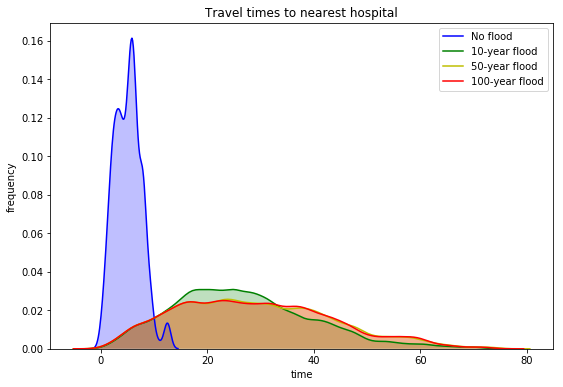

In [156]:
f,ax = plt.subplots(figsize=[9,6])
cols = ['b','g','y','r']

for n, column in enumerate(time_to_nearest_hospital.columns):
    sns.kdeplot(time_to_nearest_hospital[column],shade=True,color=cols[n])

ax.set_title('Travel times to nearest hospital')
plt.legend(['No flood','10-year flood','50-year flood','100-year flood'])
#ax.set_yticklabels([])
ax.set(xlabel="time", ylabel='frequency');

#### 11. Firms travel to business amenities

In [161]:
baseline_OD_biz_df = pd.DataFrame(
    calculate_OD(G3, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

In [163]:
flood_OD_biz_access_10yr_df = pd.DataFrame(
        calculate_OD(G_flood10, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

flood_OD_biz_access_50yr_df = pd.DataFrame(
        calculate_OD(G_flood50, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

flood_OD_biz_access_100yr_df = pd.DataFrame(
        calculate_OD(G_flood100, list(ES_points.NN), list(POIs_biz.NN), fail_value, weight='time'))

In [187]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [188]:
#baseline_n_reachable = baseline_OD_bizaccess_df[baseline_OD_bizaccess_df < threshold].count(axis=1)
#flood_10_n_reachable = flood_OD_bizaccess_10yr_df[flood_OD_bizaccess_10yr_df < threshold].count(axis=1)
#flood_50_n_reachable = flood_OD_bizaccess_50yr_df[flood_OD_bizaccess_50yr_df < threshold].count(axis=1)
#flood_100_n_reachable = flood_OD_bizaccess_100yr_df[flood_OD_bizaccess_100yr_df < threshold].count(axis=1)

In [191]:
n_reachable = pd.DataFrame({'baseline_n_reachable': baseline_OD_biz_df[baseline_OD_biz_df < threshold].count(axis=1),
                           'flood_10_n_reachable': flood_OD_biz_access_10yr_df[flood_OD_biz_access_10yr_df < threshold].count(axis=1),
                           'flood_50_n_reachable': flood_OD_biz_access_50yr_df[flood_OD_biz_access_50yr_df < threshold].count(axis=1),
                           'flood_100_n_reachable': flood_OD_biz_access_100yr_df[flood_OD_biz_access_100yr_df < threshold].count(axis=1)})

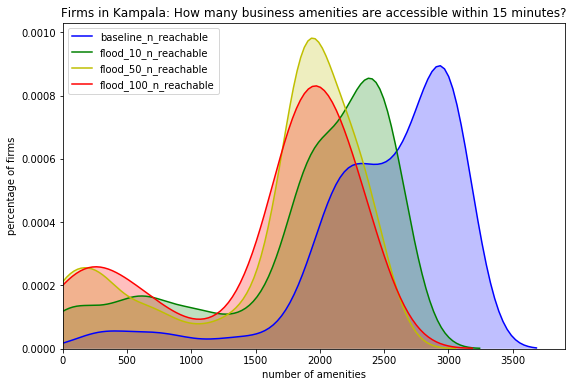

In [198]:
f,ax = plt.subplots(figsize=[9,6])

cols_to_show=['baseline_n_reachable','flood_10_n_reachable','flood_50_n_reachable','flood_100_n_reachable']
cols = ['b','g','y','r']

for n, column in enumerate(n_reachable[cols_to_show]):
    sns.kdeplot(n_reachable[column],shade=True,color=cols[n])
    
ax.set_title('Firms in Kampala: How many business amenities are accessible within {} minutes?'.format(minutes))
plt.legend(cols_to_show)
#plt.legend(['No flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="number of amenities", ylabel='percentage of firms');

#### 11. What proportion of jobs accessible within x minutes?

In [341]:
baseline_OD_jobs_df = pd.DataFrame(
    calculate_OD(G3, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN)).T

In [342]:
flood_OD_jobs_10yr_df = pd.DataFrame(
        calculate_OD(G_flood10, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

flood_OD_jobs_50yr_df = pd.DataFrame(
        calculate_OD(G_flood50, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

flood_OD_jobs_100yr_df = pd.DataFrame(
        calculate_OD(G_flood100, list(grid.NN), list(employment_points.NN), fail_value, weight='time'), index = list(grid.NN), columns = list(employment_points.NN))

In [280]:
# STEPS
# get list of nodes reachable from each grid point
# get list of employment points for which NN is the nearest node
# sum the employment in those point
# that gives you number of jobs reachable from any grid square u

print("Grid cells: {}".format(grid.shape[0]))
print("Employment points: {}".format(employment_points.shape[0]))

print("OD matrix shape: {} rows, {} columns".format(baseline_OD_jobs_df.shape[0],baseline_OD_jobs_df.shape[1]))

Grid cells: 1512
Employment points: 6228
OD matrix shape: 6228 rows, 1512 columns


In [ ]:
def calculate_values_accessible(OD_matrix, gdf, field_to_sum, threshold):
    
    ### Calculate how many jobs (or other attributes) are accessible within a given journey time.
    # REQUIRES:     OD_matrix    -  a df where index gives the NN of each origin, columns give the NN of each destination, and values are journey time in seconds.
    #               gdf          -  a gdf with points and a nearest node field (NN)
    #               field_to_sum - the gdf column to sum
    # RETURNS:      list with the sum of accessible values for each origin point.
    
    OD = OD_matrix.copy()
    
    sum_accessible_list = []

    for col in OD.columns:
        reachable_nodes = list(OD[col][OD[col] < threshold].index) # list the reachable nodes

        reachable_nodes = list(OD[col][OD[col] < threshold].index) 
        sum_accessible = gdf[field_to_sum][gdf.NN.isin(reachable_nodes)].sum()
        sum_accessible_list.append(sum_accessible)
        
    return(sum_accessible_list)

In [327]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [333]:
baseline_jobs_accessible = calculate_values_accessible(baseline_OD_jobs_df, employment_points, 'percent_jobs', threshold)
flood_10_jobs_accessible = calculate_values_accessible(flood_OD_jobs_10yr_df, employment_points, 'percent_jobs', threshold)
flood_50_jobs_accessible = calculate_values_accessible(flood_OD_jobs_50yr_df, employment_points, 'percent_jobs', threshold)
flood_100_jobs_accessible = calculate_values_accessible(flood_OD_jobs_100yr_df, employment_points, 'percent_jobs', threshold)

In [337]:
flood_OD_jobs_10yr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6218,6219,6220,6221,6222,6223,6224,6225,6226,6227
0,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
1,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
2,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
3,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15
4,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,2451.278841,2451.278841,3073.044867,2451.278841,2451.278841,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,2743.242339,2.000000e+15


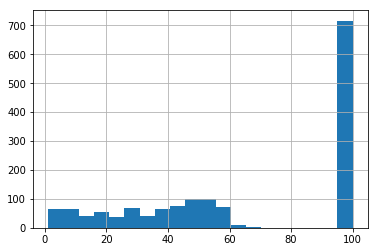

In [336]:
pd.Series(baseline_jobs_accessible).hist(bins = 20)

In [273]:
employment_points.percent_jobs[employment_points.NN.isin(list_of_reachable_nodes)].sum()

17.294893101150475

In [224]:
employment_points.head()

,Id,x_centroid,y_centroid,density,geometry,percent_jobs,x,y,NN
0,1,32.436709,0.021084,0.09,POINT (32.43670924673388 0.02108392351784156),0.001445,32.436709,0.021084,5508792311
1,2,32.441201,0.021084,2.74,POINT (32.44120082315448 0.02108392351784156),0.043996,32.441201,0.021084,5508792311
2,3,32.445692,0.021084,2.05,POINT (32.44569239957508 0.02108392351784156),0.032917,32.445692,0.021084,3892127977
3,4,32.427726,0.025606,0.28,POINT (32.42772609389268 0.02560577053669072),0.004496,32.427726,0.025606,5508792311
4,5,32.436709,0.025606,1.03,POINT (32.43670924673388 0.02560577053669072),0.016539,32.436709,0.025606,5508792311


In [221]:
baseline_OD_jobs_df.head(1)

,5508792311,5508792311,3892127977,5508792311,5508792311,5508792311,5508792311,3892127977,5508792311,5508792311,...,6216122215,6216122215,3889863642,3842552846_6830_22632,2163104626,2163104626,2163104626,2163104626,6229620127,579895174
6220689098,1770.025308,1770.025308,2511.018477,1770.025308,1770.025308,1770.025308,1770.025308,2511.018477,1770.025308,1770.025308,...,1183.212684,1183.212684,962.850366,850.515048,821.134584,821.134584,821.134584,821.134584,1709.038404,1642.015392


In [208]:
baseline_OD_jobs_df.index = list(grid.NN)
baseline_OD_jobs_df.columns = list(employment_points.NN)

In [201]:
minutes = 15
threshold = minutes * 60       # Set a threshold (minutes * 60)

In [211]:
jobs_reachable_baseline = pd.DataFrame({'baseline_jobs_reachable': baseline_OD_jobs_df[baseline_OD_jobs_df < threshold].sum(axis=1)})

In [202]:
jobs_reachable = pd.DataFrame({'baseline_jobs_reachable': baseline_OD_jobs_df[baseline_OD_jobs_df < threshold].sum(axis=1),
                           'flood_10_jobs_reachable': flood_OD_jobs_10yr_df[flood_OD_jobs_10yr_df < threshold].sum(axis=1),
                           'flood_50_jobs_reachable': flood_OD_jobs_50yr_df[flood_OD_jobs_50yr_df < threshold].sum(axis=1),
                           'flood_100_jobs_reachable': flood_OD_jobs_100yr_df[flood_OD_jobs_100yr_df < threshold].sum(axis=1)})

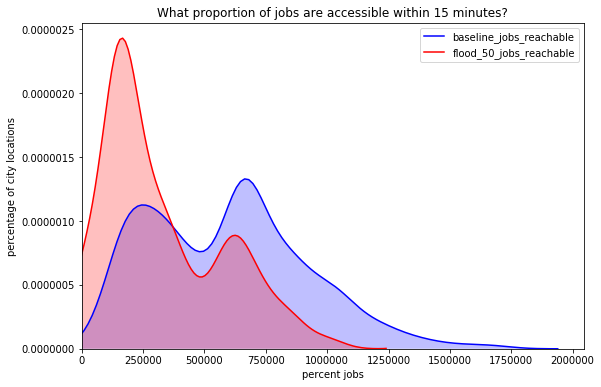

In [205]:
f,ax = plt.subplots(figsize=[9,6])

#cols_to_show=['baseline_jobs_reachable','flood_10_jobs_reachable','flood_50_jobs_reachable','flood_100_jobs_reachable']
#cols = ['b','g','y','r']

cols_to_show=['baseline_jobs_reachable','flood_50_jobs_reachable']
cols = ['b','r']

for n, column in enumerate(jobs_reachable[cols_to_show]):
    sns.kdeplot(jobs_reachable[column],shade=True,color=cols[n])
    
ax.set_title('What proportion of jobs are accessible within {} minutes?'.format(minutes))
plt.legend(cols_to_show)
#plt.legend(['No flood','50-year flood'])
plt.xlim(0)
#ax.set_yticklabels([])
ax.set(xlabel="percent jobs", ylabel='percentage of city locations');